In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [2]:
# Load the dataset
df = pd.read_csv('data/processed/cleaned_data_Emanuela.csv')


In [3]:
import warnings
warnings.filterwarnings("ignore")

# import sys
# sys.path.append('/Users/ayushyapare/Desktop/Ayushyas_Life/Work/Projects/Snippets')

# from DataFrame_Analysis import analyze_dataframe

In [4]:
# Perform EDA now
# analyze_dataframe(df)

In [5]:
df.columns

Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'is_exact_address_hidden',
       'floor', 'is_floor_under', 'rent_price', 'buy_price_by_area',
       'is_renewal_needed', 'is_new_development', 'has_central_heating',
       'has_individual_heating', 'has_ac', 'has_fitted_wardrobes', 'has_lift',
       'is_exterior', 'energy_certificate', 'has_parking',
       'is_orientation_north', 'is_orientation_west', 'is_orientation_south',
       'is_orientation_east', 'built_year', 'neighbourhood', 'district',
       'house_type'],
      dtype='object')

In [6]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'bool']).columns.tolist()

In [7]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'buy_price_by_area']]
y = df['buy_price_by_area']

In [8]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



# Initialize models
logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

ridge_classifier_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RidgeClassifier())
])

lasso_logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='saga'))
])

elastic_net_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

# Train and evaluate


In [9]:
# !pip install pycaret

In [10]:
from pycaret.regression import *

In [11]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    target = 'buy_price_by_area',
    session_id=9,
    categorical_features=['floor']
    )

,Description,Value
0,Session id,9
1,Target,buy_price_by_area
2,Target type,Regression
3,Original data shape,"(21517, 26)"
4,Transformed data shape,"(21517, 37)"
5,Transformed train set shape,"(15061, 37)"
6,Transformed test set shape,"(6456, 37)"
7,Numeric features,3
8,Categorical features,1
9,Rows with missing values,77.6%


In [12]:
# compare baseline models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,244.2201,184273.1550,426.2935,0.9498,0.0973,0.0631,3.5090
dummy,Dummy Regressor,1480.5512,3642001.3371,1907.1378,-0.0005,0.4789,0.4631,0.1110


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

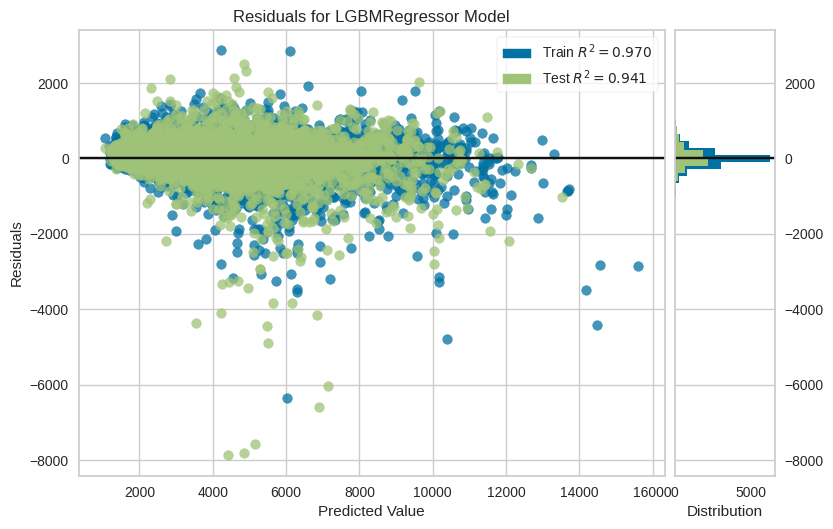

In [13]:
# plot residuals
plot_model(best_model, plot = 'residuals')

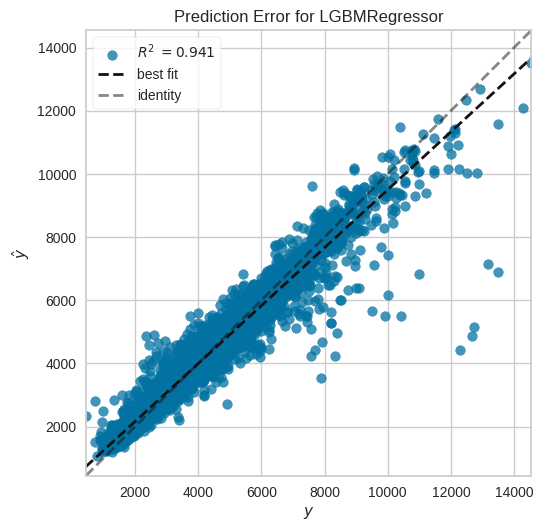

In [14]:
# plot error
plot_model(best_model, plot = 'error')

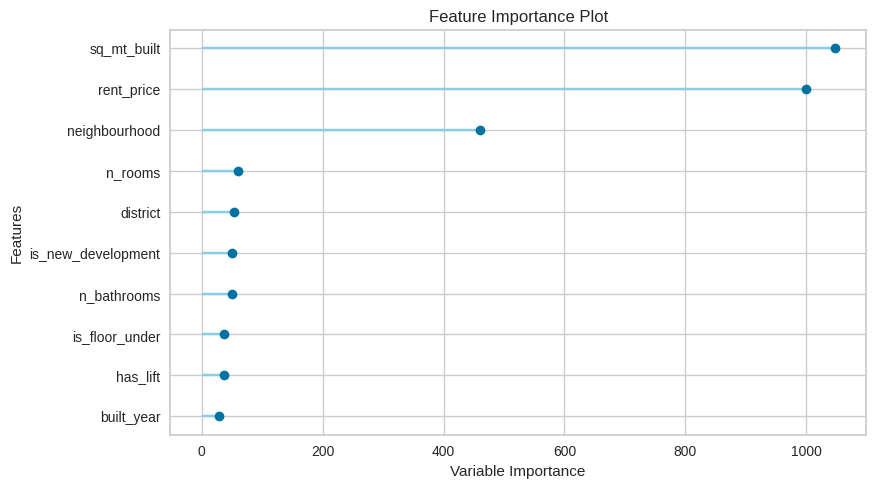

In [15]:
# plot feature importance
plot_model(best_model, plot = 'feature')

In [16]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…